<a href="https://colab.research.google.com/github/ChipsetS/AdmiralRoom/blob/master/site/zh-cn/tutorials/audio/music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 RNN 生成音乐

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/audio/music_generation"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/audio/music_generation.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/audio/music_generation.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/audio/music_generation.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

本教程向您展示如何使用简单的循环神经网络 (RNN) 生成音符。您将使用来自 [MAESTRO 数据集](https://magenta.tensorflow.org/datasets/maestro)的钢琴 MIDI 文件集合来训练模型。给定一系列音符，您的模型将学习预测序列中的下一个音符。可以通过重复调用模型来生成更长的音符序列。

本教程包含解析和创建 MIDI 文件的完整代码。可以通过访问[使用 RNN 的文本生成](https://tensorflow.google.cn/text/tutorials/text_generation)教程来详细了解 RNN 的运作方式。

## 安装

本教程使用 [`pretty_midi`](https://github.com/craffel/pretty-midi) 库创建和解析 MIDI 文件，并使用 [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) 在 Colab 中生成音频播放。

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [2]:
!pip install --upgrade pyfluidsynth

In [3]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=81902c1ace20eb4cc6facf99404de29d800809aafdf2c2670549ab3f52896b54
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## 下载 Maestro 数据集

In [6]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


该数据集包含约 1,200 个 MIDI 文件。

In [7]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## 处理 MIDI 文件

首先，使用 `pretty_midi` 解析单个 MIDI 文件并检查音符的格式。如果想下载下面的 MIDI 文件以在计算机上播放，则可以在 Colab 中通过编写 `files.download(sample_file)` 来实现。


In [8]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--4.midi


为示例 MIDI 文件生成 `PrettyMIDI` 对象。

In [9]:
pm = pretty_midi.PrettyMIDI(sample_file)

播放示例文件。播放微件可能需要几秒钟来加载。

In [20]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=100):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [21]:
display_audio(pm)

对 MIDI 文件进行一些检查。使用什么样的工具？

In [12]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## 提取音符

In [13]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=64, note_name=E4, duration=0.8151
1: pitch=64, note_name=E4, duration=0.3919
2: pitch=64, note_name=E4, duration=0.0482
3: pitch=64, note_name=E4, duration=1.2669
4: pitch=65, note_name=F4, duration=1.2969
5: pitch=64, note_name=E4, duration=1.3398
6: pitch=60, note_name=C4, duration=1.6042
7: pitch=64, note_name=E4, duration=2.3672
8: pitch=64, note_name=E4, duration=0.6510
9: pitch=60, note_name=C4, duration=0.7539


在训练模型时，将使用三个变量来表示音符：`pitch`、`step` 和 `duration`。pitch 是声音的感知质量，作为 MIDI 音符编号。`step` 是从前一个音符或曲目开始所经过的时间。`duration` 是音符将播放多长时间（以秒为单位），是音符结束时间和音符开始时间之间的差值。


从示例 MIDI 文件中提取音符。

In [14]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [15]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     64  1.037760  1.852865  0.000000  0.815104
1     64  2.308594  2.700521  1.270833  0.391927
2     64  3.174479  3.222656  0.865885  0.048177
3     64  3.412760  4.679688  0.238281  1.266927
4     65  4.531250  5.828125  1.118490  1.296875

解释音符名称可能比解释音高更容易，因此您可以使用下面的函数将数字音高值转换为音符名称。音符名称显示了音符类型、变音记号和八度数（例如 C#4）。

In [16]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['E4', 'E4', 'E4', 'E4', 'F4', 'E4', 'C4', 'E4', 'E4', 'C3'],
      dtype='<U3')

要呈现乐曲，请绘制音高、音轨（即钢琴卷帘）时长的开始点和结束点。从前 100 个音符开始

In [17]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

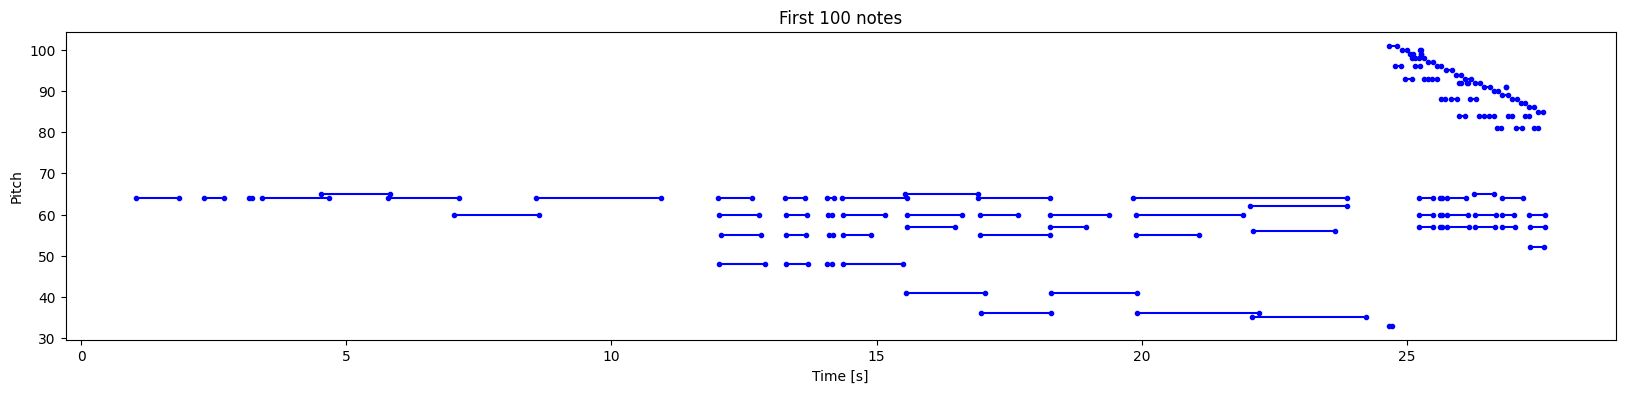

In [18]:
plot_piano_roll(raw_notes, count=100)

绘制整个音轨的音符。

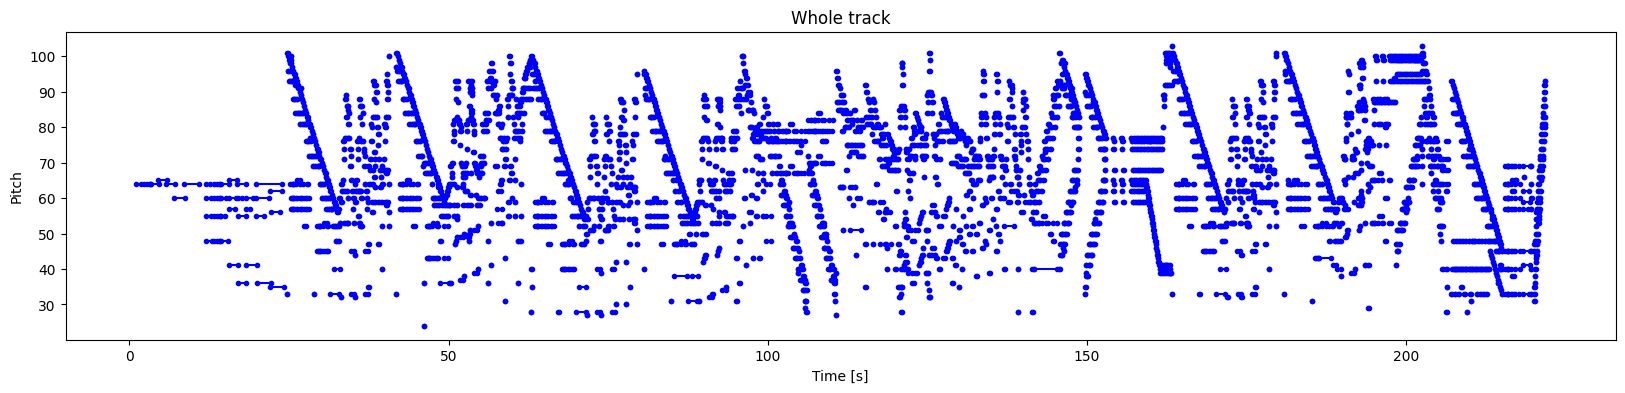

In [19]:
plot_piano_roll(raw_notes)

检查每个音符变量的分布。

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [ ]:
plot_distributions(raw_notes)

## 创建 MIDI 文件

可以使用以下函数从音符列表中生成自己的 MIDI 文件。

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

播放生成的 MIDI 文件，看看有什么区别。

In [ ]:
display_audio(example_pm)

和以前一样，可以编写 `files.download(example_file)` 来下载和播放此文件。

## 创建训练数据集


通过从 MIDI 文件中提取音符来创建训练数据集。可以先使用少量文件，然后再尝试更多文件。这可能需要几分钟。

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

接下来，从已解析的音符创建 [tf.data.Dataset](https://tensorflow.google.cn/datasets)。

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

然后，针对成批的音符序列训练模型。每个样本将包含一系列音符作为输入特征，下一个音符作为标签。通过这种方式，模型将被训练来预测序列中的下一个音符。可以在[使用 RNN 的文本分类](https://tensorflow.google.cn/text/tutorials/text_generation)中找到说明此过程的图表（以及更多详细信息）。

可以使用大小为 `seq_length` 的方便 [window](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#window) 函数来创建这种格式的特征和标签。

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

为每个样本设置序列长度。尝试不同的长度（例如 50、100、150），看看哪一个最适合数据，或者使用[超参数调优](https://tensorflow.google.cn/tutorials/keras/keras_tuner)。词汇表的大小 (`vocab_size`) 设置为 128，表示 `pretty_midi` 支持的所有音高。

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

数据集的形状为 `(100,1)`，表示模型将以 100 个音符作为输入，并学习预测以下音符作为输出。

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

对样本进行批处理，并配置数据集以提高性能。

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

## 创建并训练模型

该模型将具有三个输出，每个音符变量使用一个输出。对于 `step` 和 `duration`，将使用基于均方误差的自定义损失函数，以鼓励模型输出非负值。

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

测试 `model.evaluate` 函数，可以看到 `pitch` 损失明显大于 `step` 和 `duration` 损失。请注意，`loss` 是通过对所有其他损失求和计算得出的总损失，目前主要由 `pitch` 损失决定。

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

平衡这种情况的一种方式是使用 `loss_weights` 参数进行编译：

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

然后，`loss` 成为各个损失的加权总和。

In [ ]:
model.evaluate(train_ds, return_dict=True)

训练模型。

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## 生成音符

要使用模型生成音符，首先需要提供音符的起始序列。下面的函数可以从一系列音符中生成一个音符。

对于音符音高，它会从模型产生的音符的 softmax 分布中抽取样本，而不是简单地选择概率最高的音符。始终选择概率最高的音符会导致生成重复的音符序列。

`temperature` 参数可用于控制所生成音符的随机性。可以在[使用 RNN 的文本生成](https://tensorflow.google.cn/text/tutorials/text_generation)中详细了解温度。

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

现在，生成一些音符。可以在 `next_notes` 中调整温度和起始序列，看看会发生什么。

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

还可以通过添加以下两行来下载音频文件：

```
from google.colab import files
files.download(out_file)
```

呈现生成的音符。

In [ ]:
plot_piano_roll(generated_notes)

检查 `pitch`、`step` 和 `duration` 的分布。

In [ ]:
plot_distributions(generated_notes)

在上面的图中，您会注意到音符变量分布的变化。由于模型的输出和输入之间存在反馈回路，模型倾向于生成相似的输出序列以减少损失。这与使用 MSE 损失的 `step` 和 `duration` 特别相关。对于 `pitch`，可以通过增大 `predict_next_note` 中的 `temperature` 来增加随机性。


## 后续步骤

本教程演示了使用 RNN 从 MIDI 文件数据集中生成音符序列的机制。要了解详情，您可以访问密切相关的[使用 RNN 的文本生成](https://tensorflow.google.cn/text/tutorials/text_generation)教程，其中包含附加的图表和解释。

使用 RNN 生成音乐的一种替代方式是使用 GAN。基于 GAN 的方式并非生成音频，而是可以并行生成整个序列。Magenta 团队使用 [GANSynth](https://magenta.tensorflow.org/gansynth) 在这种方式上完成了非凡的工作。此外，还可以在 [Magenta 项目网站](https://magenta.tensorflow.org/)上找到许多精彩的音乐和艺术项目以及开源代码。